## image, label 파일 목록 list에 저장

In [14]:
# !rm -rf /content/drive/Shareddrives/msmg/level2/dataset/train/building/image/*.txt

In [15]:
import os
 
img_root_dir = '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image'
label_root_dir = '/content/drive/Shareddrives/msmg/level2/dataset/train/building/label'
img_path_list = []
label_path_list = []

possible_img_extension = ['.png'] # 이미지 확장자
possible_label_extension = ['.json'] # 라벨 확장자
 
for (root, dirs, files) in os.walk(img_root_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_img_extension:
                img_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                img_path = img_path.replace('\\', '/') # \는 \\로 나타내야함         
                img_path_list.append(img_path)
                img_path_list.sort()

for (root, dirs, files) in os.walk(label_root_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_label_extension:
                label_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                label_path = label_path.replace('\\', '/') # \는 \\로 나타내야함         
                label_path_list.append(label_path)
                label_path_list.sort()
                             
print(img_path_list)
print(label_path_list)

['/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00001_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00002_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00004_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00006_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00008_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00011_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00013_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00017_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00018_PS3_K3A_NIA0276.png', '/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00034_PS3_K3A_NIA

In [16]:
# 파일 개수 확인
print(len(img_path_list))
print(len(label_path_list))

1238
1238


In [17]:
def get_polygon_xy(ann_seg):
    polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
    polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
    polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
    polygon_xy = np.array(polygon_xy, np.int32)
    
    return polygon_xy

In [18]:
def apply_mask2(image, mask):
    image[:, :] = np.where(mask == 1, image[:, :] + 1, image[:, :])
    
    return image

In [19]:
def get_mask2(image_array_shape, polygon_xy):
    ## polygon 정보를 mask 정보로 변환. 
    zero_mask = np.zeros(image_array_shape) # mask 정보는 2차원 선호
    masked_polygon = cv2.fillPoly(zero_mask, [polygon_xy], 1)

    return masked_polygon

In [20]:
# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화. 
def draw_segment2(image_array, ann_seg_list, color_list, alpha):
    draw_image = image_array.copy()
    mask_array_shape = draw_image.shape[0:2]
    zero_mask = np.zeros(mask_array_shape)
    masked_image = zero_mask    # 지역변수 초기화

    # list형태로 입력된 segmentation 정보들을 각각 시각화
    for index, ann_seg in enumerate(ann_seg_list):
        # polygon 좌표로 변환. 
        polygon_xy = get_polygon_xy(ann_seg)

        # mask 정보 변환
        masked_polygon = get_mask2(mask_array_shape, polygon_xy)
        
        # masking 적용. 
        masked_image = apply_mask2(zero_mask, masked_polygon)

        # contour 적용
        color_contour = (0, 255, 0)

        s_mask_int = (masked_polygon*255).astype("uint8")
        contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        masked_image = cv2.drawContours(masked_image, contours, -1, 2, 3, cv2.LINE_8, hierarchy, 100) 

    return masked_image

## 건물 (컨테이너 박스와 기타 2개 class 제외) masking 정보가 담긴 txt 파일 생성

In [21]:
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np

green_color = (0, 255, 0)
color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]

for i, j in zip(img_path_list, label_path_list):

    # 원본 이미지 시각화 
    image_array = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    with open(j) as json_file:
        data_infos = json.load(json_file)

    ann_seg_list = [] # 빈 리스트 생성
    for k in range(len(data_infos['features'])):  # 이미지 내 폴리곤 개수만큼 반복
        imcoords = []
        # 건물 class가 '기타'거나 '컨테이너 박스'일 경우는 제외
        if data_infos['features'][k]['properties']['type_name'] == "\uae30\ud0c0" or data_infos['features'][k]['properties']['type_name'] == "\ucee8\ud14c\uc774\ub108 \ubc15\uc2a4":
            continue
        # 건물의 polygon 좌표가 없을 경우 제외
        if data_infos['features'][k]['properties']['building_imcoords'] == "":
            continue
        imcoords = list(map(float, data_infos['features'][k]['properties']['building_imcoords'].split(',')))

        ann_seg_list.append(imcoords)
    
    masked_image = draw_segment2(image_array, ann_seg_list, color_list, alpha=0.6)
    # masked_image[masked_image > 1] = 1
    masked_image.astype(int)
    np.savetxt(i.replace('.png', '.txt'), masked_image, fmt = '%d', delimiter = ' ')
    print(i)

/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00001_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00002_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00004_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00006_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00008_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00011_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00013_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00017_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00018_PS3_K3A_NIA0276.png
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image/BLD00034_PS3_K3A_NIA0276.png
/content/drive/Share

In [23]:
%cd /content/drive/Shareddrives/msmg/level2/dataset/train/building/image
!pwd

/content/drive/Shareddrives/msmg/level2/dataset/train/building/image
/content/drive/Shareddrives/msmg/level2/dataset/train/building/image


In [24]:
!mv *.txt ../annotation/

## MMCV, PIL, numpy로 class별 masking 및 txt -> png 파일로 변환

In [25]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.11.0+cu113 False


In [1]:
# Install MMCV
# 런타임 -> 런타임 "다시 시작" 후 아래 수행. 
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


- 0 -> background : [0, 0, 0]
- 1 -> road : [255, 0, 255]
- 2 -> building : [0, 0, 255]

In [2]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image
import cv2

# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/Shareddrives/msmg/level2/dataset/train/building'
#img_dir = 'train'
ann_dir = 'annotation'

# define class and plaette for better visualization
classes = ('background', 'building', 'border')
palette = [[0, 0, 0], [0, 0, 255], [255, 0, 0]]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [3]:
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.txt'):
    seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.txt', '.png')))

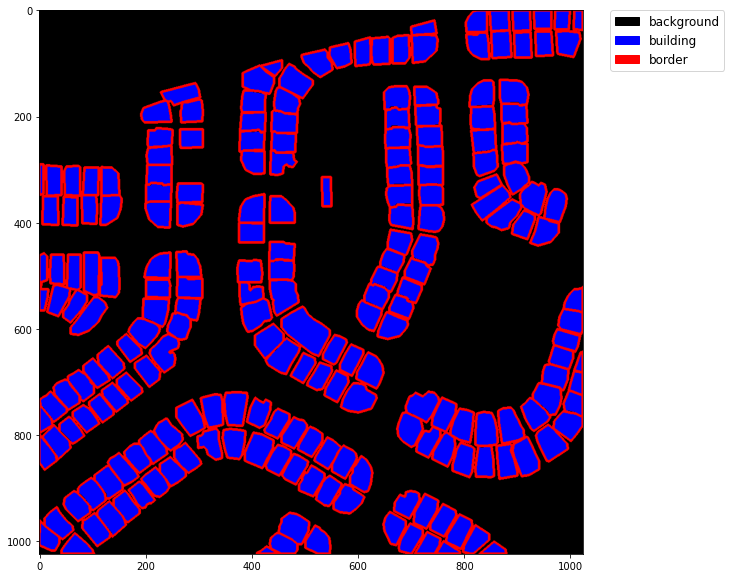

In [4]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches

img = Image.open('/content/drive/Shareddrives/msmg/level2/dataset/train/building/annotation/BLD00001_PS3_K3A_NIA0276.png')
plt.figure(figsize=(10, 10))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(3)]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()